In [1]:
!pip install -q transformers

In [2]:
import pandas as pd
df = pd.read_csv('legal_sentiment_dataset.csv')

print(df.head())

print(df['Sentiment'].value_counts())

for sentiment in df['Sentiment'].unique():
    print(f"\nSample {sentiment} examples:")
    print(df[df['Sentiment'] == sentiment].sample(3)['Legal_Text'].tolist())

   ID                                         Legal_Text Sentiment
0   1  The defendant successfully demonstrated their ...  Positive
1   2  The legal proceedings were resolved amicably, ...  Positive
2   3  The status conference was rescheduled to a lat...   Neutral
3   4  Client complaints centered around the prolonge...  Negative
4   5  The settlement was achieved efficiently, with ...  Positive
Sentiment
Negative    360
Neutral     326
Positive    314
Name: count, dtype: int64

Sample Positive examples:
['The client expressed satisfaction with the swift settlement process.', "Positive feedback was received regarding the legal counsel's performance.", 'The case concluded with favorable terms for the company, avoiding litigation.']

Sample Neutral examples:
['The hearing was adjourned until further notice.', 'The judge ordered a review of procedural aspects.', 'The court has requested additional documentation before proceeding.']

Sample Negative examples:
["The defendant's actions w

In [3]:
from transformers import AutoTokenizer, T5ForConditionalGeneration

model_name = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [4]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Sentiment'], random_state=42)

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")
print("Train class balance:\n", train_df['Sentiment'].value_counts())
print("Test class balance:\n", test_df['Sentiment'].value_counts())

Train size: 800, Test size: 200
Train class balance:
 Sentiment
Negative    288
Neutral     261
Positive    251
Name: count, dtype: int64
Test class balance:
 Sentiment
Negative    72
Neutral     65
Positive    63
Name: count, dtype: int64


In [5]:
def create_few_shot_prompt(train_df, test_text, n_examples=2):
    classes = train_df['Sentiment'].unique()
    examples = []
    for sentiment in classes:
        subset = train_df[train_df['Sentiment'] == sentiment]
        sampled = subset.sample(n_examples, random_state=42)
        for _, row in sampled.iterrows():
            examples.append(f"Legal text: {row['Legal_Text']}\nSentiment: {row['Sentiment']}")
    instruction = "Classify the sentiment of the following legal text as Positive, Negative, or Neutral.\n\n"
    prompt = instruction + "\n".join(examples) + f"\nLegal text: {test_text}\nSentiment:"
    return prompt

In [6]:
results = []
for idx, row in test_df.iterrows():
    prompt = create_few_shot_prompt(train_df, row['Legal_Text'])
    inputs = tokenizer(prompt, return_tensors="pt")
    outputs = model.generate(**inputs, max_new_tokens=7)
    pred = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    results.append({
        'Legal_Text': row['Legal_Text'],
        'True_Sentiment': row['Sentiment'],
        'Predicted_Sentiment': pred
    })

import json
print(json.dumps(results[:5], indent=2))

[
  {
    "Legal_Text": "The case was transferred to a different jurisdiction for review.",
    "True_Sentiment": "Neutral",
    "Predicted_Sentiment": "Negative"
  },
  {
    "Legal_Text": "The company was fined for repeated violations of regulatory standards.",
    "True_Sentiment": "Negative",
    "Predicted_Sentiment": "Negative"
  },
  {
    "Legal_Text": "The ruling imposed strict sanctions for the breach of contract.",
    "True_Sentiment": "Negative",
    "Predicted_Sentiment": "Negative"
  },
  {
    "Legal_Text": "Client complaints centered around the prolonged legal dispute.",
    "True_Sentiment": "Negative",
    "Predicted_Sentiment": "Negative"
  },
  {
    "Legal_Text": "The judge ordered a review of procedural aspects.",
    "True_Sentiment": "Neutral",
    "Predicted_Sentiment": "Neutral"
  }
]


In [7]:
from sklearn.metrics import classification_report

y_true = [result['True_Sentiment'] for result in results]
y_pred = [result['Predicted_Sentiment'] for result in results]

print(classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.95      1.00      0.97        72
     Neutral       1.00      0.94      0.97        65
    Positive       1.00      1.00      1.00        63

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



In [8]:
results_df = pd.DataFrame(results)
results_df.to_csv('legal_sentiment_predictions.csv', index=False)

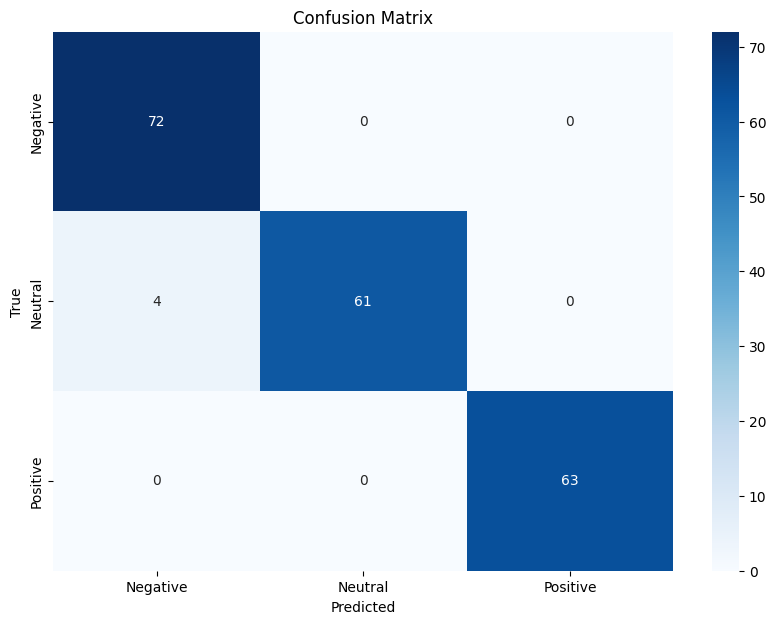

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred, labels=['Negative', 'Neutral', 'Positive'])
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

In [10]:
errors = results_df[results_df['True_Sentiment'] != results_df['Predicted_Sentiment']]
print(f"\nMisclassification Rate: {len(errors)/len(results_df):.2%}")
print("Sample Errors:")

if not errors.empty:
    sample_errors = errors.sample(min(5, len(errors)))
    print(sample_errors[['Legal_Text', 'True_Sentiment', 'Predicted_Sentiment']])
else:
    print("No misclassifications found")


Misclassification Rate: 2.00%
Sample Errors:
                                            Legal_Text True_Sentiment  \
134  The case was transferred to a different jurisd...        Neutral   
0    The case was transferred to a different jurisd...        Neutral   
51   The case was transferred to a different jurisd...        Neutral   
168  The case was transferred to a different jurisd...        Neutral   

    Predicted_Sentiment  
134            Negative  
0              Negative  
51             Negative  
168            Negative  
